In [ ]:
# Gerekli kütüphaneleri import ediyoruz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn'den model ve preprocessing araçları
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier

# Değerlendirme metrikleri
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectFromModel

# Uyarı mesajlarını kapatmak için
import warnings
warnings.filterwarnings('ignore')



In [ ]:
df = pd.read_csv('Employee.csv')


df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [ ]:
print("Eksik değerler:")
print(df.isnull().sum())

# Eğer eksik değer varsa dolduruyoruz
if df.isnull().sum().sum() > 0:
    # Sayısal kolonlar için median kullanıyoruz
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    # Kategorik kolonlar için en sık görülen değeri kullanıyoruz
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

# Kategorik değişkenleri sayısal hale getirme
encoder = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# LeaveOrNot hedef değişkenimiz, onu ayıracağız
if 'LeaveOrNot' in cat_cols:
    cat_cols.remove('LeaveOrNot')

# Her kategorik kolonu encode ediyoruz
for column in cat_cols:
    df[column] = encoder.fit_transform(df[column])


Eksik değerler:
Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64


In [ ]:
target = df['LeaveOrNot'].values
features = df.drop('LeaveOrNot', axis=1)

print(f"Toplam özellik sayısı: {features.shape[1]}")
print(f"Özellikler: {list(features.columns)}")

# Train-test split yapıyoruz
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

print(f"\nTrain set: {X_train.shape[0]} örnek")
print(f"Test set: {X_test.shape[0]} örnek")

Toplam özellik sayısı: 8
Özellikler: ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender', 'EverBenched', 'ExperienceInCurrentDomain']

Train set: 3722 örnek
Test set: 931 örnek


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso regression

lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Önemli özellikleri belirleme
feature_selector = SelectFromModel(lasso_model, prefit=True)
X_train_new = feature_selector.transform(X_train_scaled)
X_test_new = feature_selector.transform(X_test_scaled)

# özellik seçme
selected_features = features.columns[feature_selector.get_support()].tolist()
print(f"\nSeçilen özellik sayısı: {len(selected_features)}")
print(f"Seçilen özellikler: {selected_features}")


Seçilen özellik sayısı: 7
Seçilen özellikler: ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender', 'EverBenched']


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#Cross-Validation uygulama


print("Farklı modeller test ediliyor...\n")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_scores = cross_val_score(lr_model, X_train_new, y_train, cv=cv, scoring='accuracy')
print(f"Logistic Regression      : {lr_scores.mean():.4f} (+/- {lr_scores.std():.4f})")

# SVM
svm_model = SVC(probability=True, random_state=42)
svm_scores = cross_val_score(svm_model, X_train_new, y_train, cv=cv, scoring='accuracy')
print(f"SVM                      : {svm_scores.mean():.4f} (+/- {svm_scores.std():.4f})")

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt_model, X_train_new, y_train, cv=cv, scoring='accuracy')
print(f"Decision Tree            : {dt_scores.mean():.4f} (+/- {dt_scores.std():.4f})")

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_scores = cross_val_score(gb_model, X_train_new, y_train, cv=cv, scoring='accuracy')
print(f"Gradient Boosting        : {gb_scores.mean():.4f} (+/- {gb_scores.std():.4f})")

# AdaBoost
ada_model = AdaBoostClassifier(random_state=42)
ada_scores = cross_val_score(ada_model, X_train_new, y_train, cv=cv, scoring='accuracy')
print(f"AdaBoost                 : {ada_scores.mean():.4f} (+/- {ada_scores.std():.4f})")

# CV sonuçları
cv_results = {
    'Logistic Regression': lr_scores,
    'SVM': svm_scores,
    'Decision Tree': dt_scores,
    'Gradient Boosting': gb_scores,
    'AdaBoost': ada_scores
}


Farklı modeller test ediliyor...

Logistic Regression      : 0.6986 (+/- 0.0105)
SVM                      : 0.8366 (+/- 0.0082)
Decision Tree            : 0.8119 (+/- 0.0068)
Gradient Boosting        : 0.8393 (+/- 0.0144)
AdaBoost                 : 0.8023 (+/- 0.0104)


In [ ]:
print("\n1. Logistic Regression tuning...")
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    lr_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
lr_grid_search.fit(X_train_new, y_train)
best_lr_model = lr_grid_search.best_estimator_
print(f"Best parameters: {lr_grid_search.best_params_}")
print(f"Best CV score: {lr_grid_search.best_score_:.4f}")

# Gradient Boosting tuning
print("\n2. Gradient Boosting tuning...")
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
gb_grid_search.fit(X_train_new, y_train)
best_gb_model = gb_grid_search.best_estimator_
print(f"Best parameters: {gb_grid_search.best_params_}")
print(f"Best CV score: {gb_grid_search.best_score_:.4f}")

# SVM tuning
print("\n3. SVM tuning...")
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
svm_grid_search.fit(X_train_new, y_train)
best_svm_model = svm_grid_search.best_estimator_
print(f"Best parameters: {svm_grid_search.best_params_}")
print(f"Best CV score: {svm_grid_search.best_score_:.4f}")


1. Logistic Regression tuning...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.6986

2. Gradient Boosting tuning...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best CV score: 0.8477

3. SVM tuning...
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV score: 0.8404


In [ ]:
#Ensemble Learning
# En iyi 3 modeli birleştiriyoruz - Voting Classifier
print("\nEn iyi modeller birleştiriliyor...")

final_model = VotingClassifier(
    estimators=[
        ('logistic', best_lr_model),
        ('gradient_boost', best_gb_model),
        ('svm', best_svm_model)
    ],
    voting='soft'  # Olasılıkları kullanarak karar veriyor
)

# Modeli eğitiyoruz
final_model.fit(X_train_new, y_train)
print("Ensemble model hazır!")


En iyi modeller birleştiriliyor...
Ensemble model hazır!


In [ ]:
predictions = final_model.predict(X_test_new)
prediction_probas = final_model.predict_proba(X_test_new)[:, 1]

# Performans metriklerini hesaplama
test_accuracy = accuracy_score(y_test, predictions)
test_roc_auc = roc_auc_score(y_test, prediction_probas)
conf_matrix = confusion_matrix(y_test, predictions)

# Sonuçları yazdırma
print("="*60)
print("TEST SETİ SONUÇLARI")
print("="*60)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {test_roc_auc:.4f}")
print("\nDetaylı Rapor:")
print(classification_report(y_test, predictions, target_names=['Stay', 'Leave']))


TEST SETİ SONUÇLARI
Accuracy: 0.8464
ROC-AUC Score: 0.8598

Detaylı Rapor:
              precision    recall  f1-score   support

        Stay       0.83      0.96      0.89       611
       Leave       0.90      0.62      0.74       320

    accuracy                           0.85       931
   macro avg       0.86      0.79      0.81       931
weighted avg       0.85      0.85      0.84       931



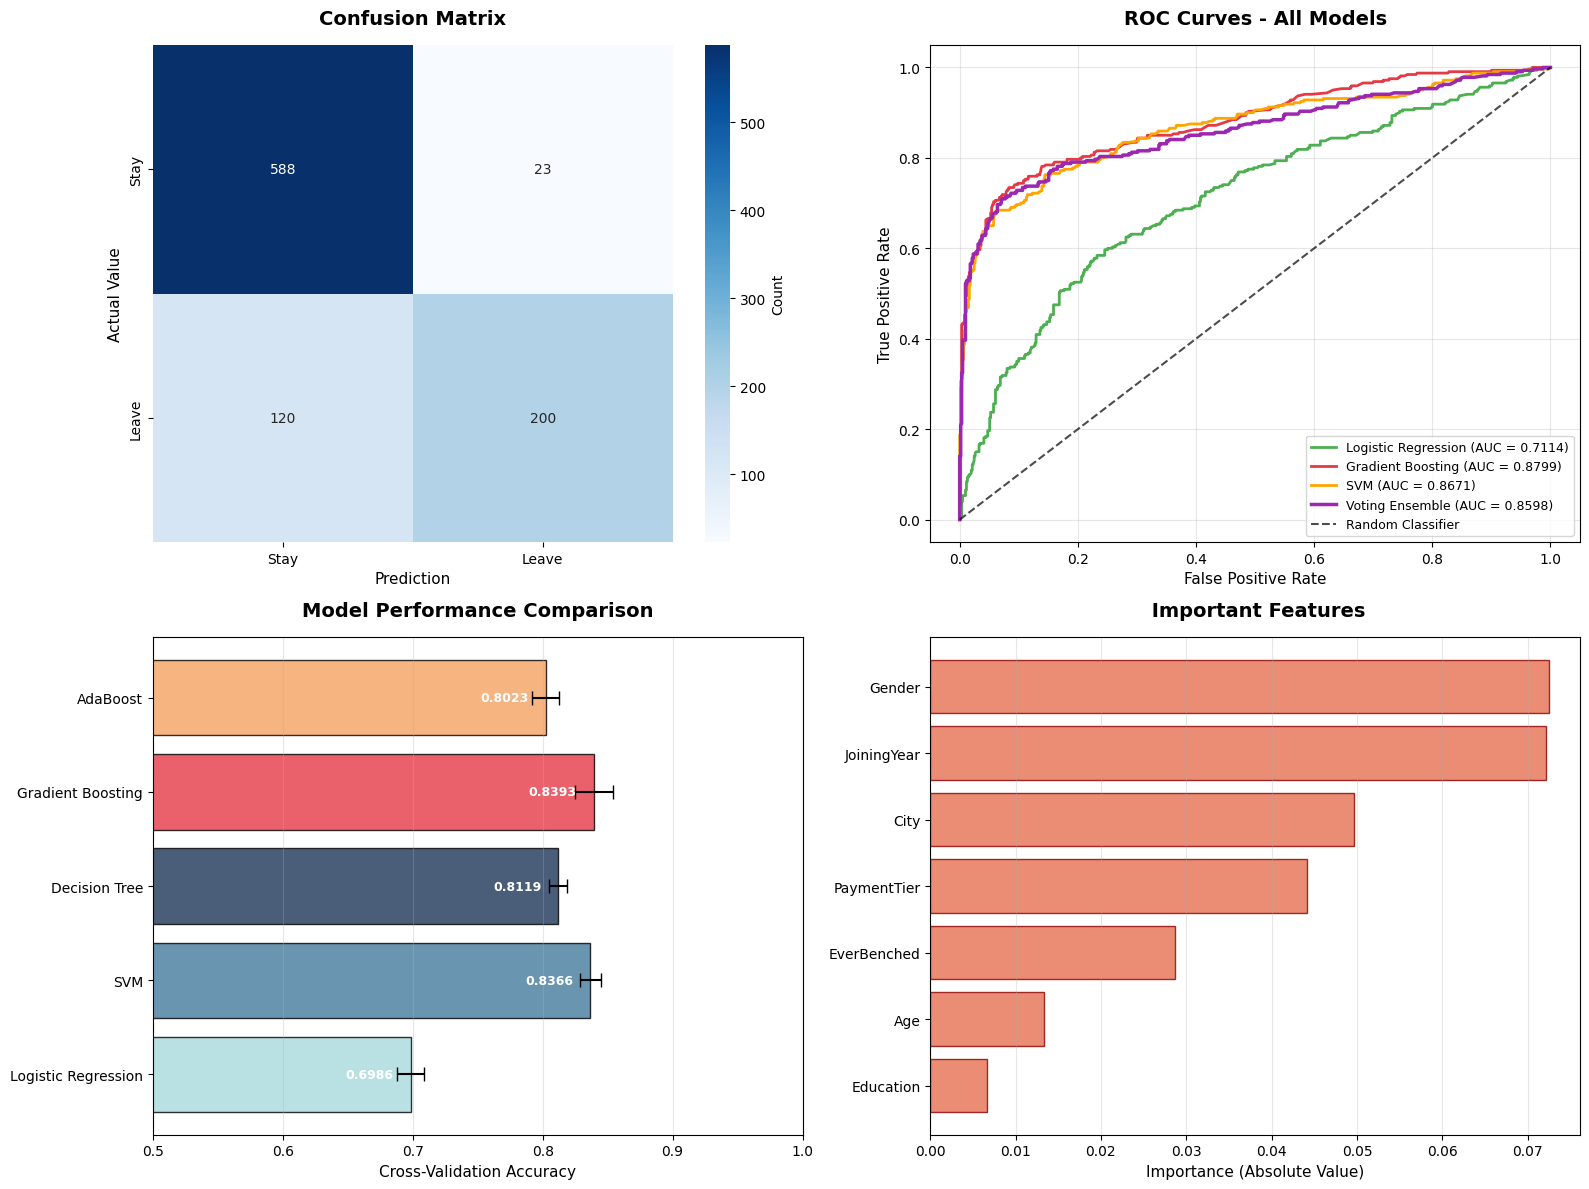


Visualization saved: model_results_1.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].set_ylabel('Actual Value', fontsize=11)
axes[0, 0].set_xlabel('Prediction', fontsize=11)
axes[0, 0].set_xticklabels(['Stay', 'Leave'])
axes[0, 0].set_yticklabels(['Stay', 'Leave'])

# 2. ROC Curve - ALL MODELS
try:
    lr_proba = best_lr_model.predict_proba(X_test_new)[:, 1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
    auc_lr = roc_auc_score(y_test, lr_proba)

    gb_proba = best_gb_model.predict_proba(X_test_new)[:, 1]
    fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)
    auc_gb = roc_auc_score(y_test, gb_proba)

    svm_proba = best_svm_model.predict_proba(X_test_new)[:, 1]
    fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
    auc_svm = roc_auc_score(y_test, svm_proba)

    fpr_voting, tpr_voting, _ = roc_curve(y_test, prediction_probas)
    auc_voting = test_roc_auc

    axes[0, 1].plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})', color='#4CAF50')
    axes[0, 1].plot(fpr_gb, tpr_gb, linewidth=2, label=f'Gradient Boosting (AUC = {auc_gb:.4f})', color='#E63946')
    axes[0, 1].plot(fpr_svm, tpr_svm, linewidth=2, label=f'SVM (AUC = {auc_svm:.4f})', color='#FFA500')
    axes[0, 1].plot(fpr_voting, tpr_voting, linewidth=2.5, label=f'Voting Ensemble (AUC = {auc_voting:.4f})', color='#9C27B0')

except NameError:
    fpr_voting, tpr_voting, _ = roc_curve(y_test, prediction_probas)
    auc_voting = test_roc_auc
    axes[0, 1].plot(fpr_voting, tpr_voting, linewidth=2.5, label=f'Voting Ensemble (AUC = {auc_voting:.4f})', color='#9C27B0')

axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.7)
axes[0, 1].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 1].set_title('ROC Curves - All Models', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].legend(loc='lower right', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# 3. Model Comparison
model_names = list(cv_results.keys())
mean_scores = [scores.mean() for scores in cv_results.values()]
std_scores = [scores.std() for scores in cv_results.values()]

colors = ['#A8DADC', '#457B9D', '#1D3557', '#E63946', '#F4A261']
bars = axes[1, 0].barh(model_names, mean_scores, xerr=std_scores,
                        capsize=5, color=colors, edgecolor='black', alpha=0.8)
axes[1, 0].set_xlabel('Cross-Validation Accuracy', fontsize=11)
axes[1, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].set_xlim([0.5, 1])
axes[1, 0].grid(axis='x', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, mean_scores)):
    axes[1, 0].text(score - 0.05, bar.get_y() + bar.get_height()/2,
                     f'{score:.4f}', va='center', fontsize=9, color='white', fontweight='bold')

# 4. Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': np.abs(lasso_model.coef_[feature_selector.get_support()])
}).sort_values('importance', ascending=True).tail(10)

axes[1, 1].barh(feature_importance_df['feature'],
                feature_importance_df['importance'],
                color='#E76F51', edgecolor='darkred', alpha=0.8)
axes[1, 1].set_xlabel('Importance (Absolute Value)', fontsize=11)
axes[1, 1].set_title(' Important Features', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_results_1.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nVisualization saved: model_results_1.png")


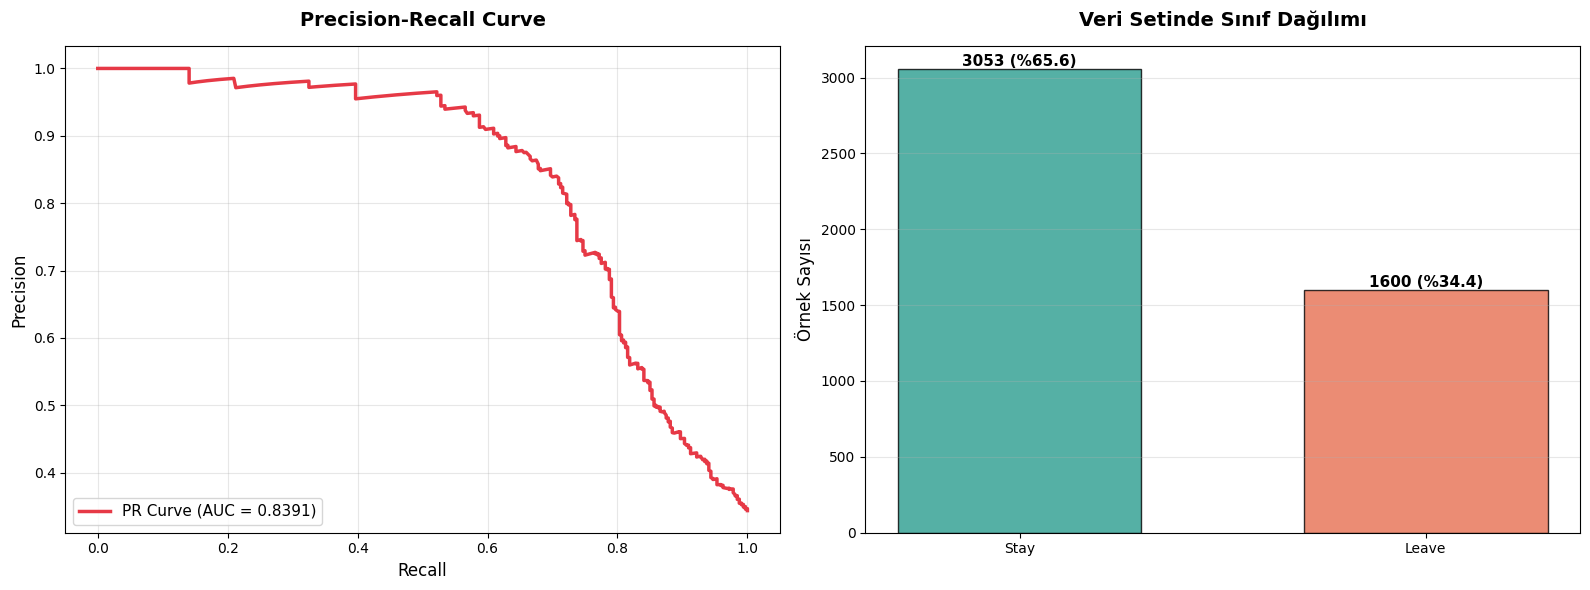

✓ Görsel kaydedildi: model_results_2.png


In [ ]:
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# 1. Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, prediction_probas)
pr_auc = auc(recall, precision)

axes2[0].plot(recall, precision, linewidth=2.5, color='#E63946',
              label=f'PR Curve (AUC = {pr_auc:.4f})')
axes2[0].set_xlabel('Recall', fontsize=12)
axes2[0].set_ylabel('Precision', fontsize=12)
axes2[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=15)
axes2[0].legend(loc='lower left', fontsize=11)
axes2[0].grid(True, alpha=0.3)

# 2. Class Distribution
class_counts = df['LeaveOrNot'].value_counts()
colors_dist = ['#2A9D8F', '#E76F51']
bars = axes2[1].bar(['Stay', 'Leave'], class_counts.values,
                     color=colors_dist, edgecolor='black', alpha=0.8, width=0.6)
axes2[1].set_ylabel('Örnek Sayısı', fontsize=12)
axes2[1].set_title('Veri Setinde Sınıf Dağılımı', fontsize=14, fontweight='bold', pad=15)
axes2[1].grid(axis='y', alpha=0.3)

# Sayıları gösteriyoruz
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    axes2[1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{int(count)} (%{count/class_counts.sum()*100:.1f})',
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('model_results_2.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Görsel kaydedildi: model_results_2.png")


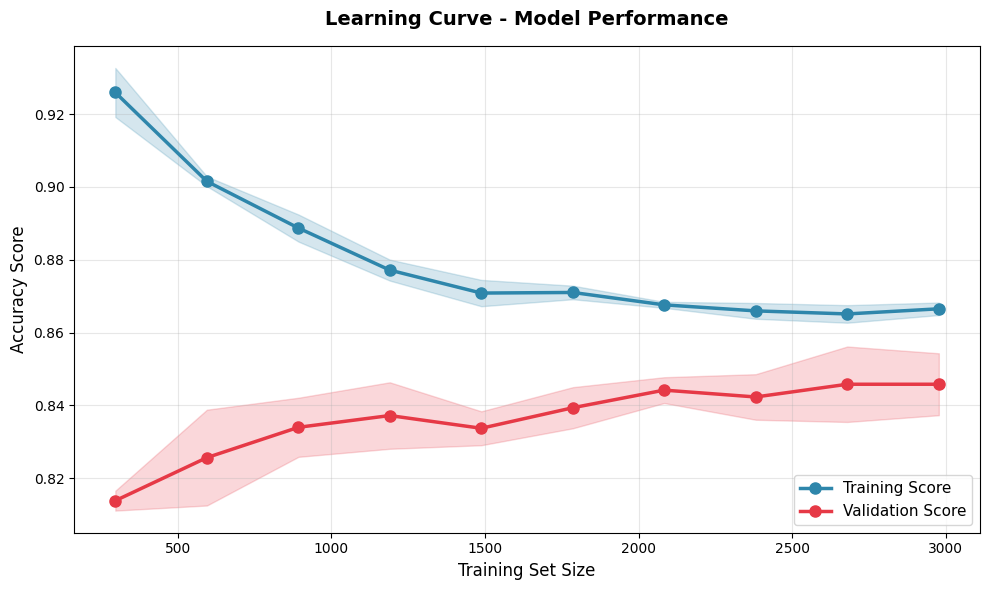

✓ Görsel kaydedildi: learning_curve.png


In [ ]:
# Learning curve için veri
train_sizes, train_scores, val_scores = learning_curve(
    final_model,
    X_train_new,
    y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    random_state=42
)

# Ortalama ve standart sapmaları hesaplama
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='#2E86AB', linewidth=2.5,
         markersize=8, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color='#2E86AB')

plt.plot(train_sizes, val_mean, 'o-', color='#E63946', linewidth=2.5,
         markersize=8, label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color='#E63946')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Learning Curve - Model Performance', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Görsel kaydedildi: learning_curve.png")

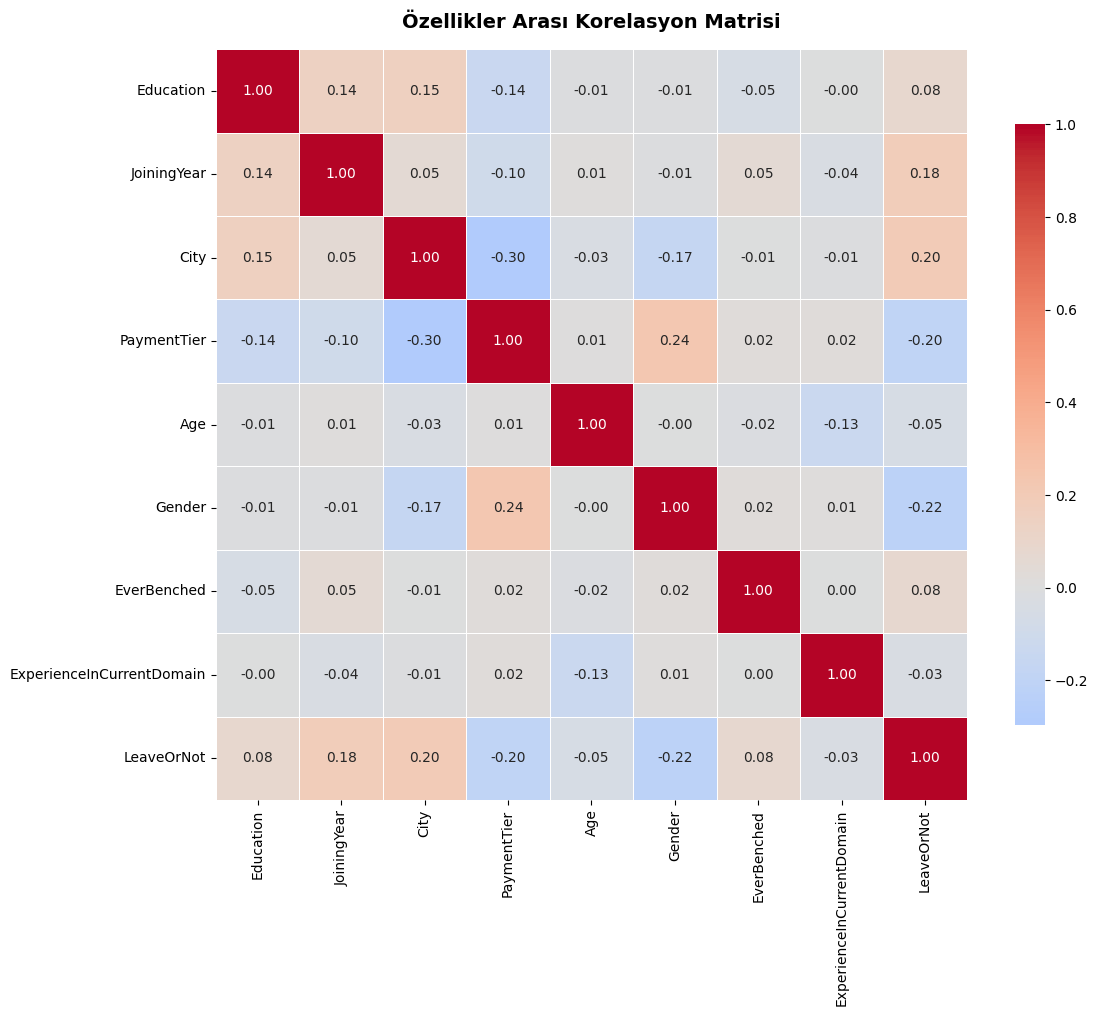

✓ Görsel kaydedildi: correlation_heatmap.png


In [ ]:
correlation_matrix = df.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Görsel kaydedildi: correlation_heatmap.png")

In [ ]:
print("\n" + "="*70)
print("DETAYLI PERFORMANS RAPORU")
print("="*70)

# test
individual_results = []

print("\nBireysel Model Performansları:")
print("-"*70)

# Logistic Regression
lr_pred = best_lr_model.predict(X_test_new)
lr_proba = best_lr_model.predict_proba(X_test_new)[:, 1]
lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_proba)
individual_results.append(['Logistic Regression', lr_acc, lr_auc])
print(f"Logistic Regression    - Accuracy: {lr_acc:.4f} | ROC-AUC: {lr_auc:.4f}")

# Gradient Boosting
gb_pred = best_gb_model.predict(X_test_new)
gb_proba = best_gb_model.predict_proba(X_test_new)[:, 1]
gb_acc = accuracy_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_proba)
individual_results.append(['Gradient Boosting', gb_acc, gb_auc])
print(f"Gradient Boosting      - Accuracy: {gb_acc:.4f} | ROC-AUC: {gb_auc:.4f}")

# SVM
svm_pred = best_svm_model.predict(X_test_new)
svm_proba = best_svm_model.predict_proba(X_test_new)[:, 1]
svm_acc = accuracy_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_proba)
individual_results.append(['SVM', svm_acc, svm_auc])
print(f"SVM                    - Accuracy: {svm_acc:.4f} | ROC-AUC: {svm_auc:.4f}")

# Ensemble
individual_results.append(['Voting Ensemble', test_accuracy, test_roc_auc])
print(f"Voting Ensemble        - Accuracy: {test_accuracy:.4f} | ROC-AUC: {test_roc_auc:.4f}")

# DataFrame oluşturma
results_table = pd.DataFrame(individual_results, columns=['Model', 'Accuracy', 'ROC-AUC'])

print("\n" + "="*70)
print("ÖZET TABLO")
print("="*70)
print(results_table.to_string(index=False))




DETAYLI PERFORMANS RAPORU

Bireysel Model Performansları:
----------------------------------------------------------------------
Logistic Regression    - Accuracy: 0.7046 | ROC-AUC: 0.7114
Gradient Boosting      - Accuracy: 0.8539 | ROC-AUC: 0.8799
SVM                    - Accuracy: 0.8475 | ROC-AUC: 0.8671
Voting Ensemble        - Accuracy: 0.8464 | ROC-AUC: 0.8598

ÖZET TABLO
              Model  Accuracy  ROC-AUC
Logistic Regression  0.704619 0.711411
  Gradient Boosting  0.853921 0.879882
                SVM  0.847476 0.867111
    Voting Ensemble  0.846402 0.859802
